In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [2]:
df = pd.read_csv('tsc.csv')

In [3]:
df.head(3).append(df.tail(3))

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
1679,2017-08-13,85993
1680,2017-08-14,85448
1681,2017-08-15,86561


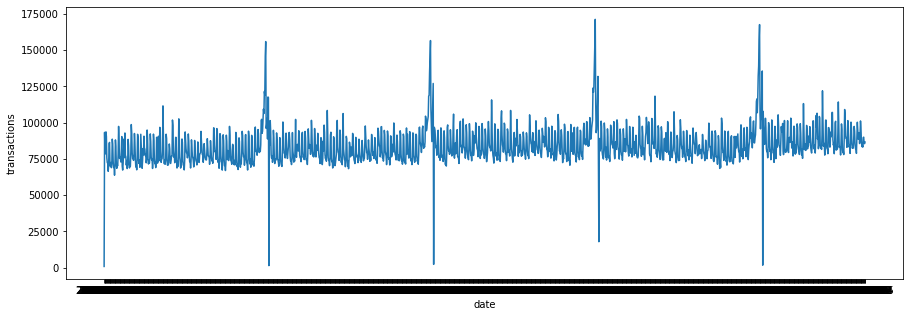

In [4]:
plt.figure(figsize=(15,5))

sns.lineplot(x='date', y='transactions', data=df)

plt.show()

In [5]:
ad_fuller_result = adfuller(df['transactions'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.95637531299986
p-value: 2.088545934367482e-07


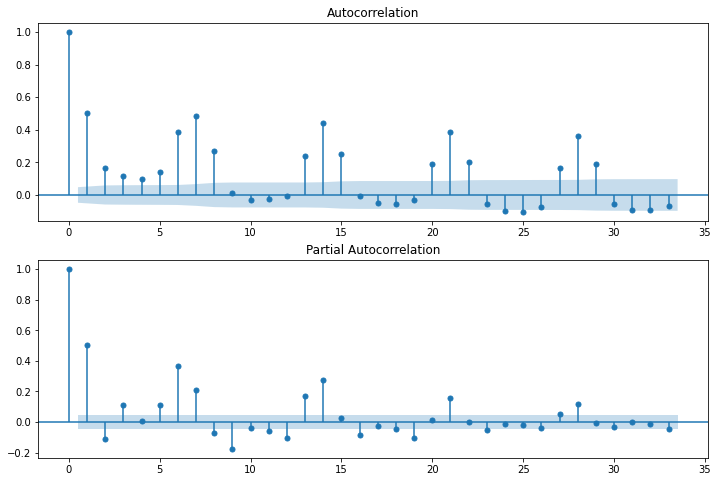

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['transactions'], ax=ax[0])
plot_pacf(df['transactions'], ax=ax[1])
plt.show()

In [7]:
train = df[:-10]
test = df[-10:]

train.tail()

,date,transactions
1667,2017-08-01,92083
1668,2017-08-02,93023
1669,2017-08-03,85521
1670,2017-08-04,91305
1671,2017-08-05,101108


In [8]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [9]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 7

In [10]:
import warnings
warnings.filterwarnings('ignore')

SARIMA_result_df = optimize_SARIMA(train['transactions'], order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 0, 2)",34956.695746
1,"(1, 2, 1, 1)",34956.880780
2,"(1, 3, 0, 2)",34958.690608
3,"(1, 2, 0, 1)",34961.516362
4,"(1, 1, 1, 1)",34961.907062
...,...,...
251,"(0, 1, 0, 0)",36074.358725
252,"(3, 0, 0, 0)",36082.315100
253,"(2, 0, 0, 0)",36120.018436
254,"(1, 0, 0, 0)",36256.857946


In [23]:
SARIMA_model = SARIMAX(train['transactions'], order=(1,1,2), seasonal_order=(0,1,2,7), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      transactions   No. Observations:                 1672
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 7)   Log Likelihood              -17472.348
Date:                           Wed, 01 Mar 2023   AIC                          34956.696
Time:                                   09:15:39   BIC                          34989.198
Sample:                                        0   HQIC                         34968.741
                                          - 1672                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0030      0.062     -0.049      0.961      -0.124       0.118
ma.L1         -0.4713      0.060     -7.857

In [24]:
SARIMA_pred = SARIMA_model_fit.get_prediction(1672, 1681).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test

,date,transactions,SARIMA_pred
1672,2017-08-06,96162,98817.707281
1673,2017-08-07,87072,87362.356047
1674,2017-08-08,83422,85474.510331
1675,2017-08-09,85452,86504.012427
1676,2017-08-10,83064,82602.528761
1677,2017-08-11,89551,90890.328162
1678,2017-08-12,89927,104005.990532
1679,2017-08-13,85993,99409.371413
1680,2017-08-14,85448,87783.729677
1681,2017-08-15,86561,86448.808941


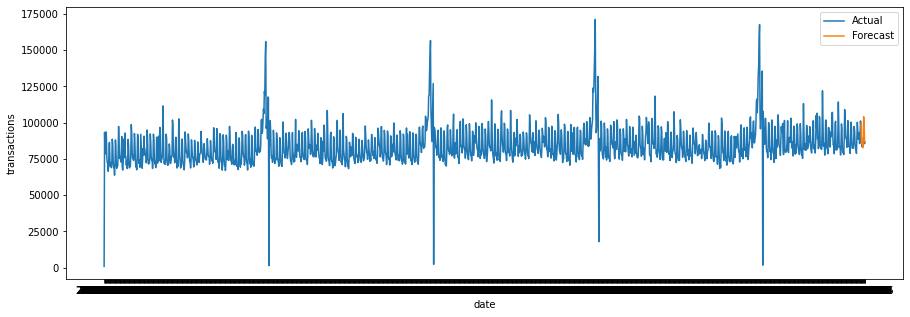

In [25]:
plt.figure(figsize=(15,5))

sns.lineplot(x='date', y='transactions', data=df, label='Actual')
sns.lineplot(x='date', y='SARIMA_pred', data=test, label='Forecast')

plt.show()

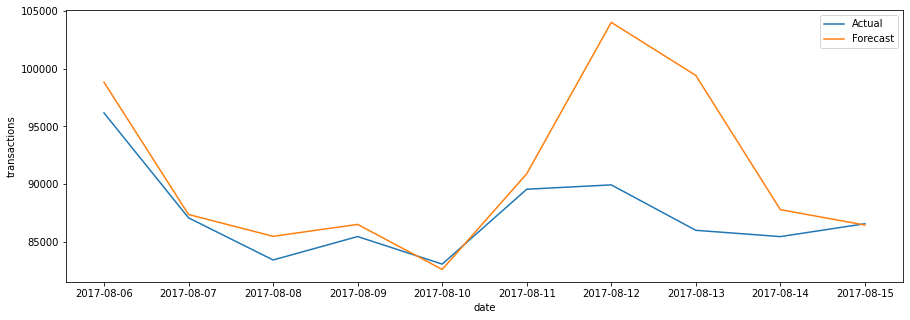

In [26]:
plt.figure(figsize=(15,5))

sns.lineplot(x='date', y='transactions', data=test, label='Actual')
sns.lineplot(x='date', y='SARIMA_pred', data=test, label='Forecast')

plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['transactions'], test['SARIMA_pred'])
print(prophet_mae)

3779.466816837429


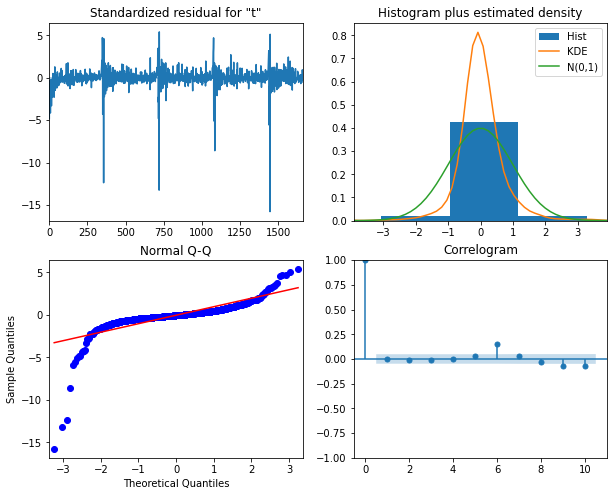

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));